In [ ]:
!unzip drive/MyDrive/train_images.zip

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'train_images/'
INPUT_SHAPE = (224,224)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.30, 
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="individual_id",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= TRAIN_DIR,
  x_col="image",
  y_col="individual_id",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 35724 validated image filenames belonging to 15587 classes.
Found 15309 validated image filenames belonging to 15587 classes.


In [ ]:
import datetime
import os
from os.path import join

def tensorboard_cb(dst, name):
  log_dir = join(dst, name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = dst)
  print(f"Tensorboard output dir: {log_dir}")
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

url_efficientnet = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

def create_model(model_url, num_classes):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=INPUT_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
efficientnet_model = create_model(model_url=url_efficientnet, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=len(train_df.individual_id.unique()))

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0")])

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

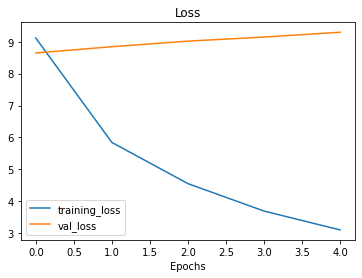

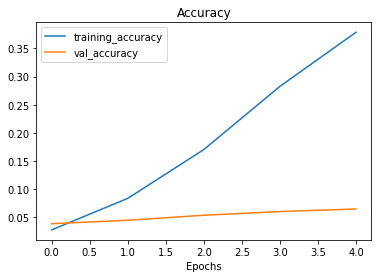

In [ ]:
plot_loss_curves(efficientnet_history)

Back to determining species

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [ ]:
len(train_df.species.unique())

26

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'train_images/'
INPUT_SHAPE = (224,224)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.30, 
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,i
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

train_generator=datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = datagen.flow_from_dataframe(
  dataframe=train_df,
  directory= TRAIN_DIR,
  x_col="image",
  y_col="species",
  subset="validation",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 35724 validated image filenames belonging to 26 classes.
Found 15309 validated image filenames belonging to 26 classes.


In [ ]:
# Create model
efficientnet_model = create_model(model_url=url_efficientnet, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=len(train_df.species.unique()))

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_species")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_species/20220228-130922
Epoch 1/5
1117/1117 [==============================] - 3884s 3s/step - loss: 0.8734 - accuracy: 0.7435 - val_loss: 0.6494 - val_accuracy: 0.8040
Epoch 2/5
1117/1117 [==============================] - 3880s 3s/step - loss: 0.5799 - accuracy: 0.8193 - val_loss: 0.5780 - val_accuracy: 0.8214
Epoch 3/5
1117/1117 [==============================] - 3897s 3s/step - loss: 0.5122 - accuracy: 0.8401 - val_loss: 0.5237 - val_accuracy: 0.8392
Epoch 4/5
1117/1117 [==============================] - 3928s 4s/step - loss: 0.4759 - accuracy: 0.8493 - val_loss: 0.5145 - val_accuracy: 0.8409
Epoch 5/5
1117/1117 [==============================] - 3935s 4s/step - loss: 0.4434 - accuracy: 0.8595 - val_loss: 0.4890 - val_accuracy: 0.8475


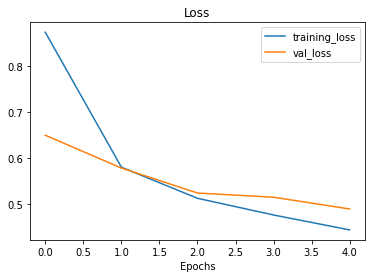

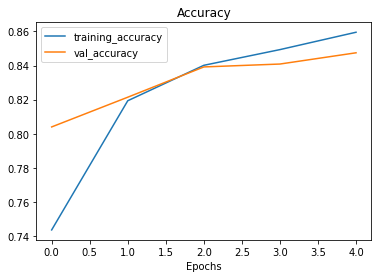

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.save('efnet_species')

INFO:tensorflow:Assets written to: efnet_species/assets


INFO:tensorflow:Assets written to: efnet_species/assets


In [ ]:
!zip -r efnet_species.zip efnet_species/

  adding: efnet_species/ (stored 0%)
  adding: efnet_species/assets/ (stored 0%)
  adding: efnet_species/keras_metadata.pb (deflated 81%)
  adding: efnet_species/saved_model.pb (deflated 92%)
  adding: efnet_species/variables/ (stored 0%)
  adding: efnet_species/variables/variables.index (deflated 79%)
  adding: efnet_species/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
!mv efnet_species.zip drive/MyDrive

In [ ]:
!zip -r tensorflow_hub.zip tensorflow_hub/

  adding: tensorflow_hub/ (stored 0%)
  adding: tensorflow_hub/train/ (stored 0%)
  adding: tensorflow_hub/train/events.out.tfevents.1646053764.29ff6df98418.87.3.v2 (deflated 92%)
  adding: tensorflow_hub/train/events.out.tfevents.1646031747.29ff6df98418.87.1.v2 (deflated 92%)
  adding: tensorflow_hub/train/events.out.tfevents.1646031581.29ff6df98418.87.0.v2 (deflated 53%)
  adding: tensorflow_hub/validation/ (stored 0%)
  adding: tensorflow_hub/validation/events.out.tfevents.1646056478.29ff6df98418.87.4.v2 (deflated 67%)
  adding: tensorflow_hub/validation/events.out.tfevents.1646034552.29ff6df98418.87.2.v2 (deflated 67%)


In [ ]:
!mv tensorflow_hub.zip drive/MyDrive

In [ ]:
train_df.loc[train_df.image == '04f84d58fa4e40.jpg'].species.max()

'white_sided_dolphin'

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
import os 
from os.path import split
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names, df):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  _, img_filename = split(filename)
  true_label = df.loc[df.image == img_filename].species.max()

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  
  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  print(f'Actual: {true_label}')
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class} {pred.max():.2f}")
  plt.axis(False);

In [ ]:
classes = train_df.species.unique()
len(classes)

26

In [ ]:
classes.sort()


In [ ]:
validation_imagenames = valid_generator.filenames
len(validation_imagenames)

15309

Actual: spotted_dolphin


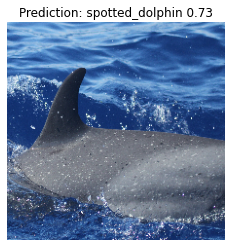

In [ ]:
import random
import os
from os.path import join, split

r = random.randint(0, len(validation_imagenames))
random_imagename = validation_imagenames[r]
image_path = join('train_images/', random_imagename)
pred_and_plot(efficientnet_model, image_path, class_names=classes)

## Split train_images

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip drive/MyDrive/train_images.zip

In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [ ]:
import math

train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)
classes = train_df.species.unique()

  

In [ ]:
len(classes)

26

In [ ]:
#df =  pd.DataFrame(columns=['image', 'individual_id', 'species', ])
#ser = train_df.loc[train_df.image == image_filenames[0]]
#pd.concat([df, ser], join='inner')


,image,individual_id,species
6516,206dcfbb2ded4f.jpg,c850b153e202,frasiers_dolphin


In [ ]:
import os
import math
import shutil 
from os.path import join

test_df =  pd.DataFrame(columns=['image', 'species', 'invididual_id', ])
!mkdir test_images
test_split = 0.20
src = 'train_images/'
dst = 'test_images/'

files_moved = 0
for cls in classes:
  class_files_moved = 0
  image_filenames = train_df.loc[train_df.species == cls].image.tolist()
  for class_file in image_filenames:
    if class_files_moved == math.ceil(test_split * len(image_filenames)):
      break
    shutil.move(join(src, class_file), join(dst, class_file))
    row = train_df.loc[train_df.image == class_file]
    test_df = pd.concat([test_df, row], join='inner')
    class_files_moved += 1
  files_moved += class_files_moved
  print(f'Moved {class_files_moved} for class {cls}')  
print(f'Total files moved: {files_moved}')


mkdir: cannot create directory ‘test_images’: File exists
Moved 338 for class melon_headed_whale
Moved 1479 for class humpback_whale
Moved 666 for class false_killer_whale
Moved 2157 for class bottlenose_dolphin
Moved 1489 for class beluga_whale
Moved 322 for class minke_whale
Moved 265 for class fin_whale
Moved 966 for class blue_whale
Moved 225 for class gray_whale
Moved 174 for class southern_right_whale
Moved 70 for class common_dolphin
Moved 491 for class killer_whale
Moved 149 for class short_finned_pilot_whale
Moved 628 for class dusky_dolphin
Moved 48 for class long_finned_pilot_whale
Moved 86 for class sei_whale
Moved 340 for class spinner_dolphin
Moved 69 for class cuviers_beaked_whale
Moved 98 for class spotted_dolphin
Moved 31 for class brydes_whale
Moved 18 for class commersons_dolphin
Moved 46 for class white_sided_dolphin
Moved 12 for class rough_toothed_dolphin
Moved 29 for class pantropic_spotted_dolphin
Moved 16 for class pygmy_killer_whale
Moved 3 for class frasiers_

In [ ]:
train_df_new = pd.concat([train_df, test_df, test_df]).drop_duplicates(keep=False)

In [ ]:
train_df_new.to_csv('train_df_new.csv')
test_df.to_csv('test_df.csv')

In [ ]:
!mkdir whales_data

In [ ]:
len(test_df)
len(train_df)

10215

In [ ]:
!mkdir valid_images

In [ ]:
import os
import math
import shutil 
from os.path import join

def split_data_and_get_df(src, dst, df, split_ratio):
  """
  Splits a dataset (folder files and dataframe)
  src = source dir
  dst = dest dir
  df = dataframe of source files
  split_ratio = the ratio to split into (ex: 0.2)

  Returns the tuple: (old dataframe - split data, split data dataframe)
  """
  df_new =  pd.DataFrame(columns=df.columns.tolist())
  
  files_moved = 0
  classes = df.species.unique().tolist()
  for cls in classes:
    class_files_moved = 0
    class_filenames = df.loc[df.species == cls].image.tolist()
    for class_file in class_filenames:
      if class_files_moved == math.ceil(test_split * len(class_filenames)):
        break
      shutil.move(join(src, class_file), join(dst, class_file))
      row = df.loc[df.image == class_file]
      df_new = pd.concat([df_new, row], join='inner')
      class_files_moved += 1
    files_moved += class_files_moved
    print(f'Moved {class_files_moved} for class {cls}')  
  print(f'Total files moved: {files_moved}')
  df_old_minus_new = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
  print(f'Length of old df: {len(df)}')
  print(f'Length of old-new_df: {len(df_old_minus_new)}')
  print(f'Length of new_df: {len(df_new)}')
  return df_old_minus_new, df_new

In [ ]:
len(train_df)

51033

In [ ]:
!mkdir valid_images
src = 'train_images/'
dst = 'valid_images/'
df_minus_valid, df_valid = split_data_and_get_df(src, dst, train_df, 0.2)

mkdir: cannot create directory ‘valid_images’: File exists
Moved 338 for class melon_headed_whale
Moved 1479 for class humpback_whale
Moved 666 for class false_killer_whale
Moved 1933 for class bottlenose_dolphin
Moved 1489 for class beluga
Moved 322 for class minke_whale
Moved 265 for class fin_whale
Moved 966 for class blue_whale
Moved 225 for class gray_whale
Moved 174 for class southern_right_whale
Moved 70 for class common_dolphin
Moved 193 for class kiler_whale
Moved 53 for class pilot_whale
Moved 628 for class dusky_dolphin
Moved 299 for class killer_whale
Moved 48 for class long_finned_pilot_whale
Moved 86 for class sei_whale
Moved 340 for class spinner_dolphin
Moved 224 for class bottlenose_dolpin
Moved 69 for class cuviers_beaked_whale
Moved 98 for class spotted_dolphin
Moved 24 for class globis
Moved 31 for class brydes_whale
Moved 18 for class commersons_dolphin
Moved 46 for class white_sided_dolphin
Moved 74 for class short_finned_pilot_whale
Moved 12 for class rough_tooth

In [ ]:
!mkdir test_images
src = 'train_images/'
dst = 'test_images/'

df_minus_valid_test, df_test = split_data_and_get_df(src, dst, df_minus_valid, 0.2)

Moved 15 for class commersons_dolphin
Moved 42 for class pilot_whale
Moved 56 for class common_dolphin
Moved 3 for class frasiers_dolphin
Moved 24 for class pantropic_spotted_dolphin
Moved 69 for class sei_whale
Moved 139 for class southern_right_whale
Moved 10 for class rough_toothed_dolphin
Moved 180 for class gray_whale
Moved 79 for class spotted_dolphin
Moved 1191 for class beluga
Moved 1547 for class bottlenose_dolphin
Moved 19 for class globis
Moved 239 for class killer_whale
Moved 503 for class dusky_dolphin
Moved 1183 for class humpback_whale
Moved 212 for class fin_whale
Moved 59 for class short_finned_pilot_whale
Moved 532 for class false_killer_whale
Moved 272 for class spinner_dolphin
Moved 37 for class white_sided_dolphin
Moved 25 for class brydes_whale
Moved 271 for class melon_headed_whale
Moved 773 for class blue_whale
Moved 258 for class minke_whale
Moved 55 for class cuviers_beaked_whale
Moved 154 for class kiler_whale
Moved 179 for class bottlenose_dolpin
Moved 38 fo

In [ ]:
df_minus_valid_test.to_csv('train_df_new.csv')
df_valid.to_csv('valid_df.csv')
df_test.to_csv('test_df.csv')

In [ ]:
!mv train_df_new.csv valid_df.csv test_df.csv valid_images test_images train_images whales_data/

In [ ]:
!zip -r whales_data.zip whales_data/


In [ ]:
!mv whales_data.zip drive/MyDrive

## Train on new dataset (split data)


In [ ]:
!unzip drive/MyDrive/whales_data.zip

In [ ]:
import pandas as pd
train_df = pd.read_csv('whales_data/train_df_new.csv')
valid_df = pd.read_csv('whales_data/valid_df.csv')
test_df = pd.read_csv('whales_data/test_df.csv')

In [ ]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)

valid_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)

test_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)


In [ ]:
len(train_df.species.unique()),len(valid_df.species.unique()),len(test_df.species.unique())

(26, 26, 26)

In [ ]:
!mkdir csv_files


In [ ]:
train_df.to_csv('csv_files/train_df_new.csv')
test_df.to_csv('csv_files/test_df.csv')
valid_df.to_csv('csv_files/valid_df.csv')

In [ ]:
!zip -r csv_files.zip csv_files/
!mv csv_files.zip drive/MyDrive

  adding: csv_files/ (stored 0%)
  adding: csv_files/.ipynb_checkpoints/ (stored 0%)
  adding: csv_files/test_df.csv (deflated 64%)
  adding: csv_files/valid_df.csv (deflated 64%)
  adding: csv_files/train_df_new.csv (deflated 62%)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'whales_data/train_images/'
VALID_DIR = 'whales_data/valid_images/'
INPUT_SHAPE = (224,224)

train_datagen=ImageDataGenerator(rescale=1./255.,
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator= train_datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe= valid_df,
  directory= VALID_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 32639 validated image filenames belonging to 26 classes.
Found 10218 validated image filenames belonging to 26 classes.


In [ ]:
efficientnet_model = create_model(model_url=url_efficientnet,
                                  num_classes=len(train_df.species.unique()))

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_new")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_new/20220301-102958
Epoch 1/5
1020/1020 [==============================] - 3117s 3s/step - loss: 0.8961 - accuracy: 0.7365 - val_loss: 0.7400 - val_accuracy: 0.7929
Epoch 2/5
1020/1020 [==============================] - 3121s 3s/step - loss: 0.5953 - accuracy: 0.8187 - val_loss: 0.6349 - val_accuracy: 0.8090
Epoch 3/5
1020/1020 [==============================] - 3099s 3s/step - loss: 0.5233 - accuracy: 0.8365 - val_loss: 0.6066 - val_accuracy: 0.8127
Epoch 4/5
1020/1020 [==============================] - 3099s 3s/step - loss: 0.4844 - accuracy: 0.8471 - val_loss: 0.6107 - val_accuracy: 0.8046
Epoch 5/5
1020/1020 [==============================] - 3152s 3s/step - loss: 0.4595 - accuracy: 0.8561 - val_loss: 0.6145 - val_accuracy: 0.8032


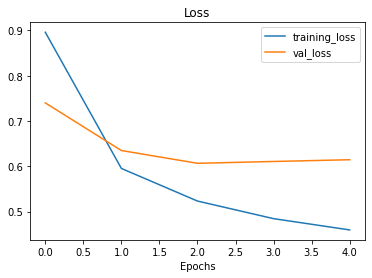

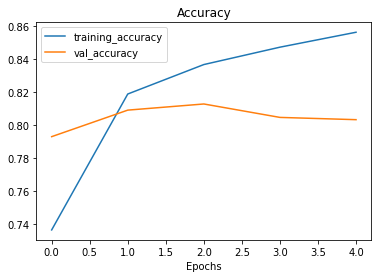

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.save('efnet_newdata')
!zip -r efnet_new_data.zip efnet_newdata/
!zip -r tensorflow_hub_newdata.zip tensorflow_hub/
!mv efnet_new_data.zip tensorflow_hub_newdata.zip drive/MyDrive

In [ ]:
!mv efnet_new_data.zip tensorflow_hub_newdata.zip drive/MyDrive

mv: cannot stat 'efnet_new_data.zip': No such file or directory


In [ ]:
classes = train_df.species.unique()
classes.sort()

Actual: bottlenose_dolphin


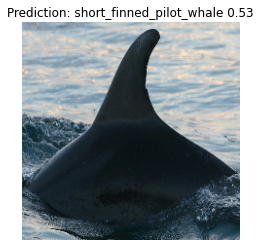

In [ ]:
import random
import os
from os.path import join, split

validation_imagenames = valid_generator.filenames
r = random.randint(0, len(validation_imagenames))
random_imagename = validation_imagenames[r]
image_path = join('whales_data/valid_images/', random_imagename)
pred_and_plot(efficientnet_model, image_path, class_names=classes, df=valid_df)

Actual: brydes_whale


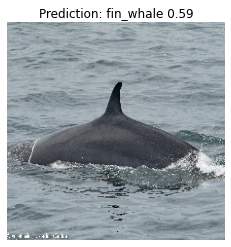

In [ ]:
class_to_test = 'brydes_whale'
class_images = valid_df.loc[valid_df.species == class_to_test].image.tolist()
image_path = join('whales_data/valid_images/', class_images[23])
pred_and_plot(efficientnet_model, image_path, class_names=classes, df=valid_df)

In [ ]:
Y_pred = efficientnet_model.predict(valid_generator)

In [ ]:
classes.tolist()

['beluga_whale',
 'blue_whale',
 'bottlenose_dolphin',
 'brydes_whale',
 'commersons_dolphin',
 'common_dolphin',
 'cuviers_beaked_whale',
 'dusky_dolphin',
 'false_killer_whale',
 'fin_whale',
 'frasiers_dolphin',
 'gray_whale',
 'humpback_whale',
 'killer_whale',
 'long_finned_pilot_whale',
 'melon_headed_whale',
 'minke_whale',
 'pantropic_spotted_dolphin',
 'pygmy_killer_whale',
 'rough_toothed_dolphin',
 'sei_whale',
 'short_finned_pilot_whale',
 'southern_right_whale',
 'spinner_dolphin',
 'spotted_dolphin',
 'white_sided_dolphin']

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred, target_names=classes))

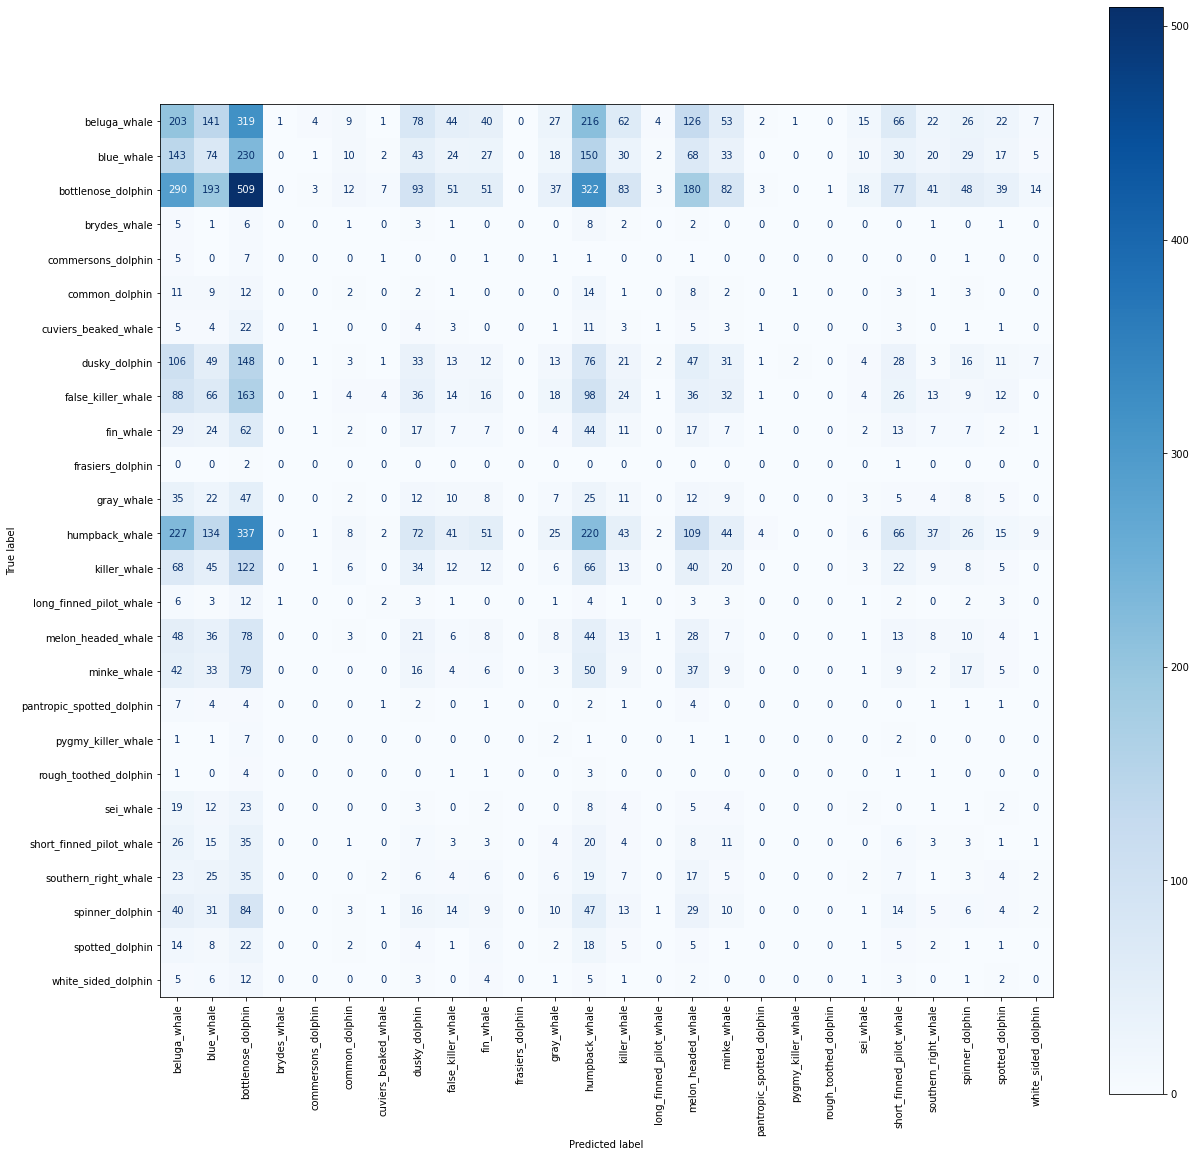

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


y_pred = np.argmax(Y_pred, axis=1)
y_test = valid_generator.classes
labels = classes.tolist()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)
for label in ax.get_xticklabels():
  label.set_rotation(90)
#plt.show()


## Under sampling attempt

In [ ]:
!unzip drive/MyDrive/train_images.zip

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [ ]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)

In [ ]:
len(train_df.species.unique())

26

In [ ]:
train_df.species.value_counts()

bottlenose_dolphin           10781
beluga_whale                  7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

Let's get a 100 images of each class

In [ ]:
!unzip drive/MyDrive/whales_data.zip
!unzip drive/MyDrive/csv_files.zip

Streaming output truncated to the last 5000 lines.
  inflating: whales_data/test_images/455b215c432341.jpg  
  inflating: whales_data/test_images/4c020a2e18b9f0.jpg  
  inflating: whales_data/test_images/37d317f41ce46e.jpg  
  inflating: whales_data/test_images/3ee99574ce2c79.jpg  
  inflating: whales_data/test_images/38291cb8276c3c.jpg  
  inflating: whales_data/test_images/3d26885bf0267f.jpg  
  inflating: whales_data/test_images/4211699bf1524b.jpg  
  inflating: whales_data/test_images/498ae390d41b1e.jpg  
  inflating: whales_data/test_images/5005284b3a7e0d.jpg  
  inflating: whales_data/test_images/421c4b616e26f9.jpg  
  inflating: whales_data/test_images/3d2c38e9eeb79d.jpg  
  inflating: whales_data/test_images/38f1ea4e09c165.jpg  
  inflating: whales_data/test_images/48d3c471a84648.jpg  
  inflating: whales_data/test_images/479bff046f1cf0.jpg  
  inflating: whales_data/test_images/3ff9e25ac03c83.jpg  
  inflating: whales_data/test_images/35681fc455171e.jpg  
  inflating: whales_d

In [ ]:
import os
import math
import shutil 
from os.path import join

def reduce_data_and_get_df(src, dst, df, max_imgs=100):
  """
  Copies a reduced dataset to max images per class (folder files and dataframe)
  src = source dir
  dst = dest dir
  df = dataframe of source files
  max_imgs = max images per class

  Returns the tuple: (old dataframe - split data, split data dataframe)
  """
  df_new =  pd.DataFrame(columns=df.columns.tolist())
  
  files_moved = 0
  classes = df.species.unique().tolist()
  for cls in classes:
    class_files_moved = 0
    class_filenames = df.loc[df.species == cls].image.tolist()
    for class_file in class_filenames:
      if class_files_moved == max_imgs:
        break
      #shutil.move(join(src, class_file), join(dst, class_file))
      shutil.copy2(join(src, class_file), join(dst, class_file))
      row = df.loc[df.image == class_file]
      df_new = pd.concat([df_new, row], join='inner')
      class_files_moved += 1
    files_moved += class_files_moved
    print(f'Copied {class_files_moved} for class {cls}')  
  print(f'Total files moved: {files_moved}')
  df_old_minus_new = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
  print(f'Length of old df: {len(df)}')
  print(f'Length of old-new_df: {len(df_old_minus_new)}')
  print(f'Length of new_df: {len(df_new)}')
  return df_old_minus_new, df_new

In [ ]:
!mkdir 100_train
!mkdir 100_valid

In [ ]:
train_df = pd.read_csv('csv_files/train_df_new.csv')
valid_df = pd.read_csv('csv_files/valid_df.csv')

In [ ]:
_, reduced_train_df = reduce_data_and_get_df('whales_data/train_images/', '100_train/', train_df )

In [ ]:
_, reduced_valid_df = reduce_data_and_get_df('whales_data/valid_images/', '100_valid/', valid_df )

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '100_train/'
VALID_DIR = '100_valid/'
INPUT_SHAPE = (224,224)

train_datagen=ImageDataGenerator(rescale=1./255.,
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator= train_datagen.flow_from_dataframe(
  dataframe=train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe= valid_df,
  directory= VALID_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 30298 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 8292 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2341 validated image filenames belonging to 26 classes.
Found 1926 validated image filenames belonging to 26 classes.


In [ ]:
efficientnet_model = create_model(model_url=url_efficientnet,
                                  num_classes=len(train_df.species.unique()))

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, 
                                              epochs=10, 
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_100_img")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_100_img/20220302-130813
Epoch 1/10
74/74 [==============================] - 335s 4s/step - loss: 2.5223 - accuracy: 0.2990 - val_loss: 2.0559 - val_accuracy: 0.4756
Epoch 2/10
74/74 [==============================] - 311s 4s/step - loss: 1.7200 - accuracy: 0.5463 - val_loss: 1.6830 - val_accuracy: 0.5576
Epoch 3/10
74/74 [==============================] - 310s 4s/step - loss: 1.4198 - accuracy: 0.6220 - val_loss: 1.5201 - val_accuracy: 0.5976
Epoch 4/10
74/74 [==============================] - 310s 4s/step - loss: 1.2465 - accuracy: 0.6613 - val_loss: 1.3941 - val_accuracy: 0.6070
Epoch 5/10
74/74 [==============================] - 307s 4s/step - loss: 1.1234 - accuracy: 0.7040 - val_loss: 1.3510 - val_accuracy: 0.6028
Epoch 6/10
74/74 [==============================] - 307s 4s/step - loss: 1.0318 - accuracy: 0.7249 - val_loss: 1.2655 - val_accuracy: 0.6371
Epoch 7/10
74/74 [==============================] - 309s 4s/step - loss: 0.9

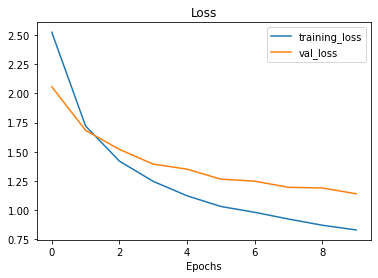

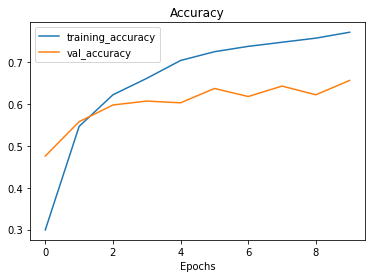

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
Y_pred = efficientnet_model.predict(valid_generator)

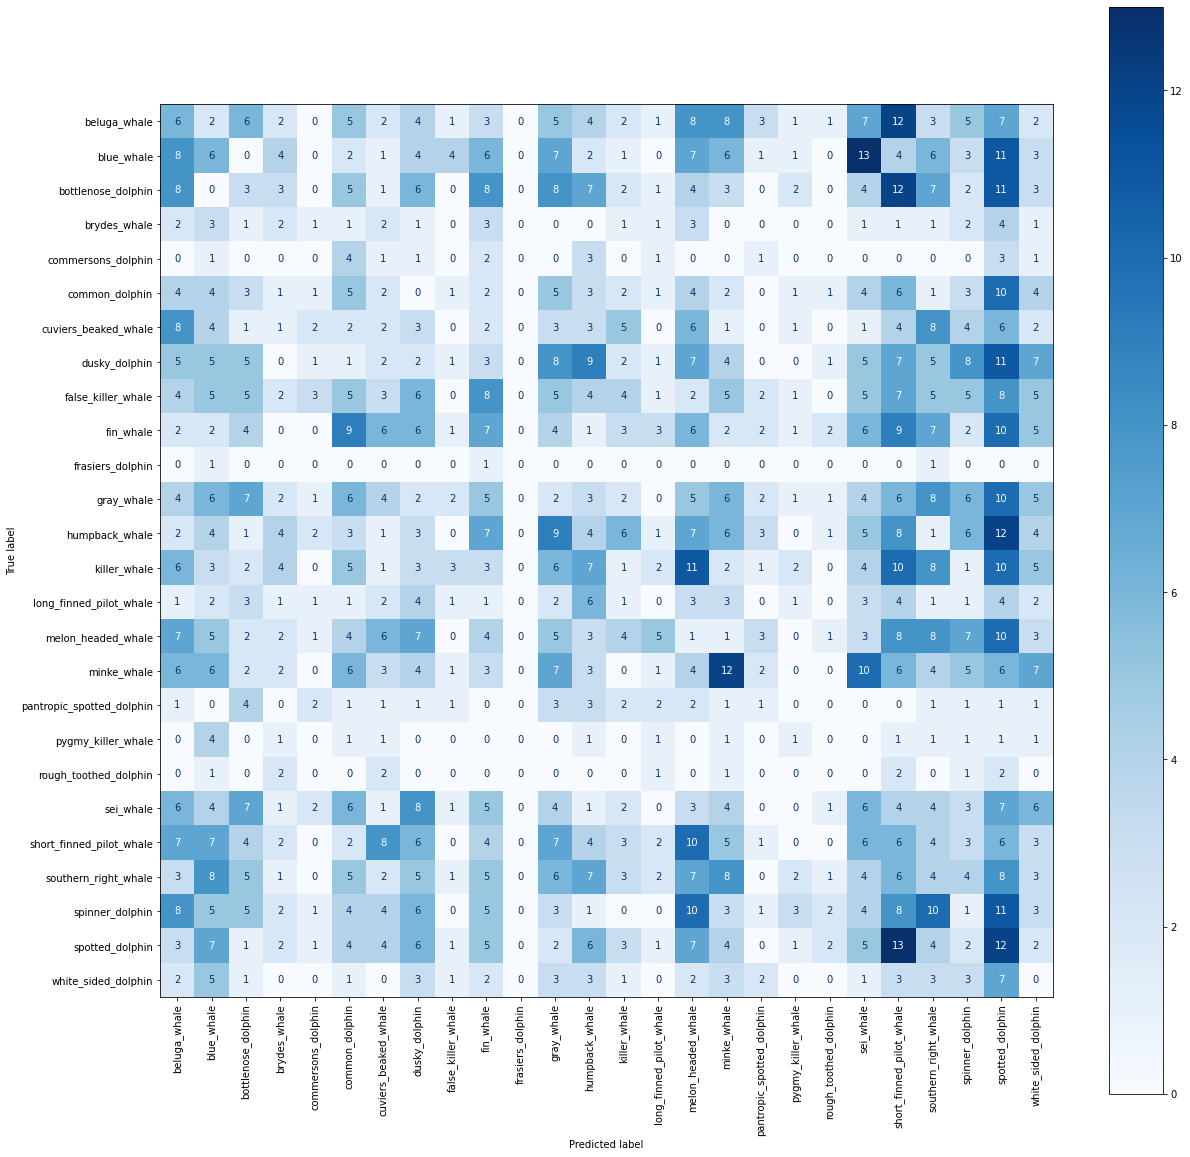

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

classes = train_df.species.unique()
classes.sort()

y_pred = np.argmax(Y_pred, axis=1)
y_test = valid_generator.classes
labels = classes.tolist()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)
for label in ax.get_xticklabels():
  label.set_rotation(90)
#plt.show()


## Only classes with 1000 images

In [ ]:
!unzip drive/MyDrive/whales_data.zip
!unzip drive/MyDrive/csv_files.zip

In [ ]:
import pandas as pd
train_df = pd.read_csv('csv_files/train_df_new.csv')
valid_df = pd.read_csv('csv_files/valid_df.csv')

In [ ]:
class_counts = train_df.species.value_counts()

In [ ]:
for i, class_count in enumerate(class_counts):
  print(class_count, i)

6898 0
4763 1
4730 2
3091 3
2128 4
2008 5
1570 6
1088 7
1080 8
1028 9
847 10
718 11
553 12
474 13
313 14
273 15
221 16
217 17
152 18
146 19
98 20
92 21
57 22
48 23
38 24
8 25


In [ ]:
top_10_classes = class_counts[:10]
top_10_classes

bottlenose_dolphin    6898
beluga_whale          4763
humpback_whale        4730
blue_whale            3091
false_killer_whale    2128
dusky_dolphin         2008
killer_whale          1570
spinner_dolphin       1088
melon_headed_whale    1080
minke_whale           1028
Name: species, dtype: int64

In [ ]:
import os
import math
import shutil 
from os.path import join

def copy_data_and_get_df(src, dst, df, num_classes=10, max_imgs=100):
  """
  Copies a dataset to max images per class (folder files and dataframe)
  src = source dir
  dst = dest dir
  df = dataframe of source files
  num_classes = number of (top) classes to copy (default: 10)
  max_imgs = max images per class

  Returns the tuple: (old dataframe - split data, split data dataframe)
  """
  df_new =  pd.DataFrame(columns=df.columns.tolist())
  
  files_moved = 0
  #classes = df.species.unique().tolist()
  # modified for top ten classes 
  class_counts = train_df.species.value_counts()
  top_10_classes = class_counts[:num_classes]
  classes = top_10_classes.index.tolist()
  print(f'Classes to move: {classes}')
  for cls in classes:
    class_files_moved = 0
    class_filenames = df.loc[df.species == cls].image.tolist()
    for class_file in class_filenames:
      if class_files_moved == max_imgs:
        break
      #shutil.move(join(src, class_file), join(dst, class_file))
      shutil.copy2(join(src, class_file), join(dst, class_file))
      row = df.loc[df.image == class_file]
      df_new = pd.concat([df_new, row], join='inner')
      class_files_moved += 1
    files_moved += class_files_moved
    print(f'Copied {class_files_moved} for class {cls}')  
  print(f'Total files copied: {files_moved}')
  df_old_minus_new = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
  print(f'Length of old df: {len(df)}')
  print(f'Length of old-new_df: {len(df_old_minus_new)}')
  print(f'Length of new_df: {len(df_new)}')
  return df_old_minus_new, df_new

In [ ]:
ls -al top_10_train/

total 576
drwxr-xr-x 2 root root 581632 Mar  2 16:33 ./
drwxr-xr-x 1 root root   4096 Mar  2 16:30 ../


In [ ]:
len(top_10_classes)

10

In [ ]:
_, reduced_train_df = reduce_data_and_get_df('whales_data/train_images/', 'top_10_train/', train_df, 1000)
_, reduced_valid_df = reduce_data_and_get_df('whales_data/valid_images/', 'top_10_valid/', valid_df, 1000)

Classes to move: ['bottlenose_dolphin', 'beluga_whale', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'killer_whale', 'spinner_dolphin', 'melon_headed_whale', 'minke_whale']
Copied 1000 for class bottlenose_dolphin
Copied 1000 for class beluga_whale
Copied 1000 for class humpback_whale
Copied 1000 for class blue_whale
Copied 1000 for class false_killer_whale
Copied 1000 for class dusky_dolphin
Copied 1000 for class killer_whale
Copied 1000 for class spinner_dolphin
Copied 1000 for class melon_headed_whale
Copied 1000 for class minke_whale
Total files moved: 10000
Length of old df: 32639
Length of old-new_df: 22639
Length of new_df: 10000
Classes to move: ['bottlenose_dolphin', 'beluga_whale', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'killer_whale', 'spinner_dolphin', 'melon_headed_whale', 'minke_whale']
Copied 1000 for class bottlenose_dolphin
Copied 1000 for class beluga_whale
Copied 1000 for class humpback_whale
Copied 966 for cl

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'top_10_train/'
VALID_DIR = 'top_10_valid/'
INPUT_SHAPE = (224,224)

train_datagen=ImageDataGenerator(rescale=1./255.,
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator= train_datagen.flow_from_dataframe(
  dataframe= reduced_train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe= reduced_valid_df,
  directory= VALID_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 10000 validated image filenames belonging to 10 classes.
Found 6752 validated image filenames belonging to 10 classes.


In [ ]:
efficientnet_model = create_model(model_url=url_efficientnet,
                                  num_classes=len(top_10_classes))

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, 
                                              epochs=10, 
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_top_10_classes")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_top_10_classes/20220302-164337
Epoch 1/10
313/313 [==============================] - 1115s 4s/step - loss: 0.9363 - accuracy: 0.7116 - val_loss: 0.6934 - val_accuracy: 0.7767
Epoch 2/10
313/313 [==============================] - 1089s 3s/step - loss: 0.5698 - accuracy: 0.8215 - val_loss: 0.5650 - val_accuracy: 0.8198
Epoch 3/10
313/313 [==============================] - 1094s 4s/step - loss: 0.4908 - accuracy: 0.8431 - val_loss: 0.5343 - val_accuracy: 0.8196
Epoch 4/10
313/313 [==============================] - 1089s 3s/step - loss: 0.4434 - accuracy: 0.8545 - val_loss: 0.5124 - val_accuracy: 0.8257
Epoch 5/10
313/313 [==============================] - 1100s 4s/step - loss: 0.4148 - accuracy: 0.8673 - val_loss: 0.5045 - val_accuracy: 0.8232
Epoch 6/10
313/313 [==============================] - 1118s 4s/step - loss: 0.3961 - accuracy: 0.8693 - val_loss: 0.4764 - val_accuracy: 0.8374
Epoch 7/10
313/313 [==============================]

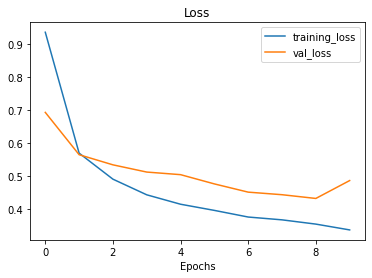

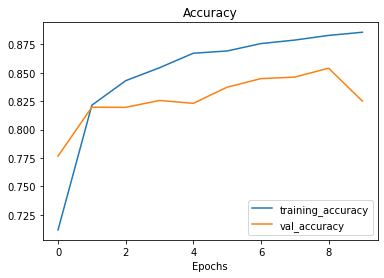

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
Y_pred = efficientnet_model.predict(valid_generator)

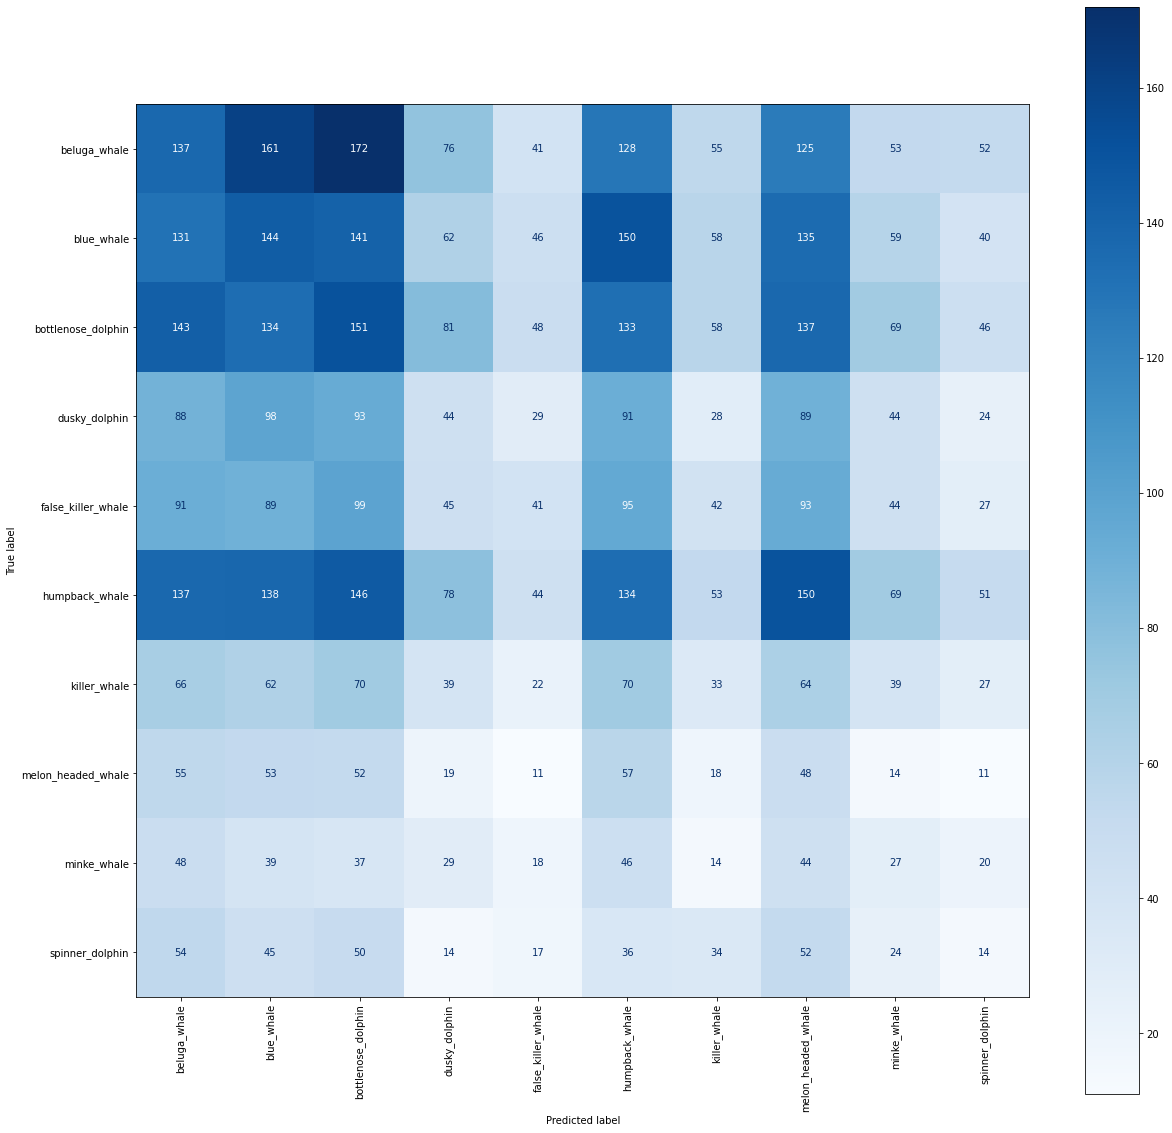

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

class_counts = train_df.species.value_counts()
top_10_classes = class_counts[:10]
classes = top_10_classes.index.tolist()
classes.sort()

y_pred = np.argmax(Y_pred, axis=1)
y_test = valid_generator.classes
labels = classes

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)
for label in ax.get_xticklabels():
  label.set_rotation(90)
#plt.show()


Actual: humpback_whale


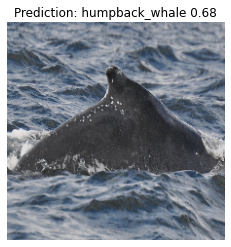

In [ ]:
import random
import os
from os.path import join, split

validation_imagenames = valid_generator.filenames
r = random.randint(0, len(validation_imagenames))
random_imagename = validation_imagenames[r]
image_path = join('top_10_valid/', random_imagename)
pred_and_plot(efficientnet_model, image_path, classes, valid_df)

In [ ]:
efficientnet_model.evaluate(x=valid_generator)

211/211 [==============================] - 401s 2s/step - loss: 0.4866 - accuracy: 0.8251


[0.48660776019096375, 0.8250888586044312]

## Cropped images (detic)

In [ ]:
!unzip drive/MyDrive/cropped_train_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: cropped_train_images/e7bc059aee4278.jpg  
  inflating: cropped_train_images/e7bdb883f8c192.jpg  
  inflating: cropped_train_images/e7be23bf6653c8.jpg  
  inflating: cropped_train_images/e7be96514ee807.jpg  
  inflating: cropped_train_images/e7c0df0b76833c.jpg  
  inflating: cropped_train_images/e7c17317474d34.jpg  
  inflating: cropped_train_images/e7c36c00dd51af.jpg  
  inflating: cropped_train_images/e7c7fef8d408ca.jpg  
  inflating: cropped_train_images/e7ca953a8b7a2e.jpg  
  inflating: cropped_train_images/e7d1574453ba7f.jpg  
  inflating: cropped_train_images/e7d1cdb2fdf583.jpg  
  inflating: cropped_train_images/e7d2503911061d.jpg  
  inflating: cropped_train_images/e7d2b70e19ca38.jpg  
  inflating: cropped_train_images/e7d4d607c23594.jpg  
  inflating: cropped_train_images/e7d925d05331af.jpg  
  inflating: cropped_train_images/e7da024ea3cc0b.jpg  
  inflating: cropped_train_images/e7dc4488aad32e.jpg  
  inflating: c

In [ ]:
!unzip train2.csv.zip

Archive:  train2.csv.zip
  inflating: train2.csv              


In [ ]:
import pandas as pd

train_df = pd.read_csv('train2.csv')

In [ ]:
train_df.species.unique()

array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'kiler_whale', 'pilot_whale', 'dusky_dolphin',
       'killer_whale', 'long_finned_pilot_whale', 'sei_whale',
       'spinner_dolphin', 'bottlenose_dolpin', 'cuviers_beaked_whale',
       'spotted_dolphin', 'globis', 'brydes_whale', 'commersons_dolphin',
       'white_sided_dolphin', 'short_finned_pilot_whale',
       'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
       'pygmy_killer_whale', 'frasiers_dolphin'], dtype=object)

In [ ]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)
classes = train_df.species.unique()
len(classes)

26

In [ ]:
len(train_df.loc[train_df.species == 'frasiers_dolphin'])

,image,species,individual_id,box
6516,206dcfbb2ded4f.jpg,frasiers_dolphin,c850b153e202,91 77 532 295
7230,2426a2a1c36d96.jpg,frasiers_dolphin,ebdbc40f5a23,0 64 415 281
8500,2ab9d2f1aa8856.jpg,frasiers_dolphin,8129c58c5831,2 77 512 295
8890,2c8aa9d93b8acb.jpg,frasiers_dolphin,6f5dc212bc7f,NaN
15347,4d817d2f3e6298.jpg,frasiers_dolphin,3a44ec1f15be,11 4 74 50
32745,a4ba8467334624.jpg,frasiers_dolphin,689c0367b3e0,0 37 239 181
33738,a98cd31ce49adc.jpg,frasiers_dolphin,689c0367b3e0,6 95 764 377
35149,b0798ddfe1409f.jpg,frasiers_dolphin,db741f696fc0,1 168 636 553
35329,b16911ad4ee3ca.jpg,frasiers_dolphin,6058acc72949,121 70 390 230
36302,b66649b72a9dee.jpg,frasiers_dolphin,7cb448ac51d9,110 91 693 475


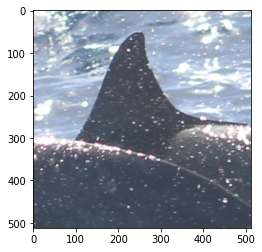

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('cropped_train_images/e80a0ca52d1b81.jpg')
imgplot = plt.imshow(img)


In [ ]:
!mkdir cropped_train_split
!mkdir cropped_valid_split
!mkdir cropped_test_split

In [ ]:
rm -rf cropped_*

In [ ]:
import os
import math
import shutil 
from os.path import join

def split_data_and_get_df(src, dst, df, split_ratio):
  """
  Splits a dataset (folder files and dataframe)
  src = source dir
  dst = dest dir
  df = dataframe of source files
  split_ratio = the ratio to split into (ex: 0.2)

  Returns the tuple: (old dataframe - split data, split data dataframe)
  """
  df_new =  pd.DataFrame(columns=df.columns.tolist())
  
  files_moved = 0
  classes = df.species.unique().tolist()
  for cls in classes:
    class_files_moved = 0
    class_filenames = df.loc[df.species == cls].image.tolist()
    for class_file in class_filenames:
      if class_files_moved == math.ceil(split_ratio * len(class_filenames)):
        break
      shutil.move(join(src, class_file), join(dst, class_file))
      row = df.loc[df.image == class_file]
      df_new = pd.concat([df_new, row], join='inner')
      class_files_moved += 1
    files_moved += class_files_moved
    print(f'Moved {class_files_moved} for class {cls}')  
  print(f'Total files moved: {files_moved}')
  df_old_minus_new = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
  print(f'Length of old df: {len(df)}')
  print(f'Length of old-new_df: {len(df_old_minus_new)}')
  print(f'Length of new_df: {len(df_new)}')
  return df_old_minus_new, df_new

In [ ]:
src = 'cropped_train_images/'
dst = 'cropped_valid_split/'
df_minus_valid, df_valid = split_data_and_get_df(src, dst, train_df, 0.2)

Moved 338 for class melon_headed_whale
Moved 1479 for class humpback_whale
Moved 666 for class false_killer_whale
Moved 2157 for class bottlenose_dolphin
Moved 1489 for class beluga_whale
Moved 322 for class minke_whale
Moved 265 for class fin_whale
Moved 966 for class blue_whale
Moved 225 for class gray_whale
Moved 174 for class southern_right_whale
Moved 70 for class common_dolphin
Moved 491 for class killer_whale
Moved 149 for class short_finned_pilot_whale
Moved 628 for class dusky_dolphin
Moved 48 for class long_finned_pilot_whale
Moved 86 for class sei_whale
Moved 340 for class spinner_dolphin
Moved 69 for class cuviers_beaked_whale
Moved 98 for class spotted_dolphin
Moved 31 for class brydes_whale
Moved 18 for class commersons_dolphin
Moved 46 for class white_sided_dolphin
Moved 12 for class rough_toothed_dolphin
Moved 29 for class pantropic_spotted_dolphin
Moved 16 for class pygmy_killer_whale
Moved 3 for class frasiers_dolphin
Total files moved: 10215
Length of old df: 51033
L

In [ ]:
src = 'cropped_train_images/'
dst = 'cropped_test_split/'
df_minus_valid_and_test, df_test = split_data_and_get_df(src, dst, df_minus_valid, 0.2)

Moved 15 for class commersons_dolphin
Moved 56 for class common_dolphin
Moved 3 for class frasiers_dolphin
Moved 24 for class pantropic_spotted_dolphin
Moved 120 for class short_finned_pilot_whale
Moved 69 for class sei_whale
Moved 139 for class southern_right_whale
Moved 10 for class rough_toothed_dolphin
Moved 180 for class gray_whale
Moved 79 for class spotted_dolphin
Moved 1191 for class beluga_whale
Moved 503 for class dusky_dolphin
Moved 1183 for class humpback_whale
Moved 212 for class fin_whale
Moved 1725 for class bottlenose_dolphin
Moved 532 for class false_killer_whale
Moved 272 for class spinner_dolphin
Moved 393 for class killer_whale
Moved 37 for class white_sided_dolphin
Moved 25 for class brydes_whale
Moved 271 for class melon_headed_whale
Moved 773 for class blue_whale
Moved 258 for class minke_whale
Moved 55 for class cuviers_beaked_whale
Moved 38 for class long_finned_pilot_whale
Moved 12 for class pygmy_killer_whale
Total files moved: 8175
Length of old df: 40818
Le

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'cropped_train_images/'
VALID_DIR = 'cropped_valid_split/'
INPUT_SHAPE = (224,224)

train_datagen=ImageDataGenerator(rescale=1./255.,
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator= train_datagen.flow_from_dataframe(
  dataframe= df_minus_valid_and_test,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe= df_valid,
  directory= VALID_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 32643 validated image filenames belonging to 26 classes.
Found 10215 validated image filenames belonging to 26 classes.


In [ ]:
efficientnet_model = create_model(model_url=url_efficientnet,
                                  num_classes=len(classes))

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, 
                                              epochs=10, 
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator)*0.25,
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_cropped")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_cropped/20220303-080714
Epoch 1/10
1021/1021 [==============================] - 611s 583ms/step - loss: 0.9215 - accuracy: 0.7351 - val_loss: 0.8008 - val_accuracy: 0.7672
Epoch 2/10
1021/1021 [==============================] - 572s 560ms/step - loss: 0.6129 - accuracy: 0.8108 - val_loss: 0.6782 - val_accuracy: 0.8000
Epoch 3/10
1021/1021 [==============================] - 567s 555ms/step - loss: 0.5415 - accuracy: 0.8334 - val_loss: 0.6294 - val_accuracy: 0.8113
Epoch 4/10
1021/1021 [==============================] - 567s 555ms/step - loss: 0.5007 - accuracy: 0.8454 - val_loss: 0.6256 - val_accuracy: 0.8047
Epoch 5/10
1021/1021 [==============================] - 567s 555ms/step - loss: 0.4639 - accuracy: 0.8553 - val_loss: 0.6264 - val_accuracy: 0.7973
Epoch 6/10
1021/1021 [==============================] - 565s 553ms/step - loss: 0.4506 - accuracy: 0.8591 - val_loss: 0.6218 - val_accuracy: 0.8113
Epoch 7/10
1021/1021 [============

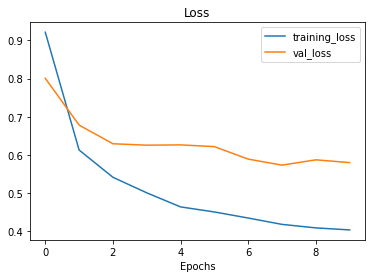

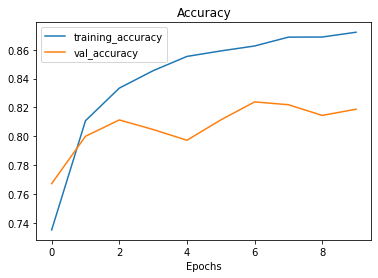

In [ ]:
plot_loss_curves(efficientnet_history)


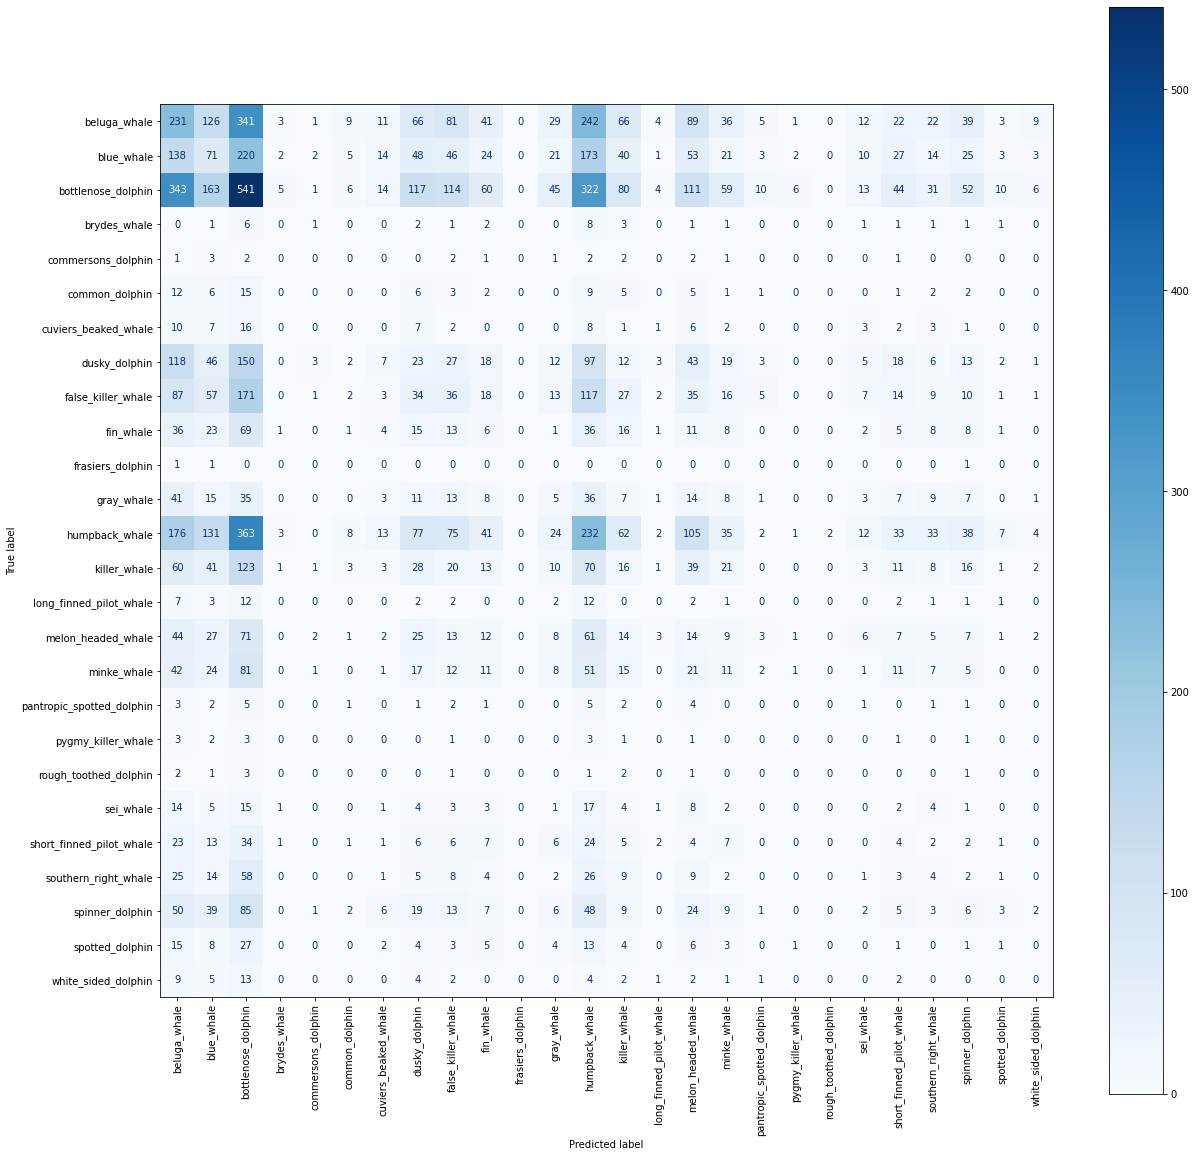

In [ ]:
Y_pred = efficientnet_model.predict(valid_generator)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#class_counts = train_df.species.value_counts()
#top_10_classes = class_counts[:10]
#classes = top_10_classes.index.tolist()
classes.sort()

y_pred = np.argmax(Y_pred, axis=1)
y_test = valid_generator.classes
labels = classes

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)
for label in ax.get_xticklabels():
  label.set_rotation(90)
#plt.show()


## Cropped top 10 classes...

In [ ]:
!unzip drive/MyDrive/cropped_train_images.zip

In [ ]:
train_df = pd.read_csv('train2.csv')



In [ ]:
top_10_classes = train_df.species.value_counts()[:10].tolist()




In [ ]:
!rm -rf top_10*

In [ ]:
!mkdir top_10_train
!mkdir top_10_valid
!mkdir top_10_test

In [ ]:
src = 'cropped_train_images/'
dst = 'top_10_train/'
train_minus_t10_train_df, top_10_train_df = copy_data_and_get_df(src, dst, train_df, max_imgs=500)

Classes to move: ['bottlenose_dolphin', 'beluga', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'spinner_dolphin', 'melon_headed_whale', 'minke_whale', 'killer_whale']
Copied 500 for class bottlenose_dolphin
Copied 500 for class beluga
Copied 500 for class humpback_whale
Copied 500 for class blue_whale
Copied 500 for class false_killer_whale
Copied 500 for class dusky_dolphin
Copied 500 for class spinner_dolphin
Copied 500 for class melon_headed_whale
Copied 500 for class minke_whale
Copied 500 for class killer_whale
Total files copied: 5000
Length of old df: 51033
Length of old-new_df: 46033
Length of new_df: 5000


In [ ]:
src = 'cropped_train_images/'
dst = 'top_10_valid/'
train_minus_t10_train_valid_df, top_10_valid_df = copy_data_and_get_df(src, dst, train_minus_t10_train_df, max_imgs=700)

Classes to move: ['bottlenose_dolphin', 'beluga', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'spinner_dolphin', 'melon_headed_whale', 'minke_whale', 'killer_whale']
Copied 500 for class bottlenose_dolphin
Copied 500 for class beluga
Copied 500 for class humpback_whale
Copied 500 for class blue_whale
Copied 500 for class false_killer_whale
Copied 500 for class dusky_dolphin
Copied 500 for class spinner_dolphin
Copied 500 for class melon_headed_whale
Copied 500 for class minke_whale
Copied 500 for class killer_whale
Total files copied: 5000
Length of old df: 46033
Length of old-new_df: 41033
Length of new_df: 5000


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'top_10_train/'
VALID_DIR = 'top_10_valid/'
INPUT_SHAPE = (224,224)

train_datagen=ImageDataGenerator(rescale=1./255.,
  rotation_range=20, 
  shear_range=0.2, 
  zoom_range=0.2, 
  width_shift_range=0.2,
  height_shift_range=0.2,
  preprocessing_function=tf.image.rgb_to_grayscale)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator= train_datagen.flow_from_dataframe(
  dataframe= top_10_train_df,
  directory=TRAIN_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

valid_generator = valid_datagen.flow_from_dataframe(
  dataframe= top_10_valid_df,
  directory= VALID_DIR,
  x_col="image",
  y_col="species",
  batch_size=32,
  seed=42,
  shuffle=False,
  class_mode="categorical",
  target_size=INPUT_SHAPE)

Found 5000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


In [ ]:
efficientnet_model = create_model(model_url=url_efficientnet,
                                  num_classes=len(top_10_classes.index.tolist()))

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, 
                                              epochs=20, 
                                              steps_per_epoch=len(train_generator),
                                              validation_data=valid_generator,
                                              validation_steps=len(valid_generator),
                                              callbacks=[tensorboard_cb(dst="tensorflow_hub", 
                                              name="efficientnetB0_cropped_t10")])

Tensorboard output dir: tensorflow_hub/efficientnetB0_cropped_t10/20220303-114700
Epoch 1/20
157/157 [==============================] - 119s 698ms/step - loss: 1.2077 - accuracy: 0.6362 - val_loss: 0.9282 - val_accuracy: 0.7318
Epoch 2/20
157/157 [==============================] - 108s 691ms/step - loss: 0.7101 - accuracy: 0.7830 - val_loss: 0.7468 - val_accuracy: 0.7928
Epoch 3/20
157/157 [==============================] - 108s 689ms/step - loss: 0.5815 - accuracy: 0.8194 - val_loss: 0.6775 - val_accuracy: 0.7966
Epoch 4/20
157/157 [==============================] - 108s 691ms/step - loss: 0.5339 - accuracy: 0.8350 - val_loss: 0.6412 - val_accuracy: 0.8006
Epoch 5/20
157/157 [==============================] - 108s 689ms/step - loss: 0.4878 - accuracy: 0.8450 - val_loss: 0.6141 - val_accuracy: 0.8008
Epoch 6/20
157/157 [==============================] - 108s 687ms/step - loss: 0.4580 - accuracy: 0.8564 - val_loss: 0.6177 - val_accuracy: 0.7950
Epoch 7/20
157/157 [======================

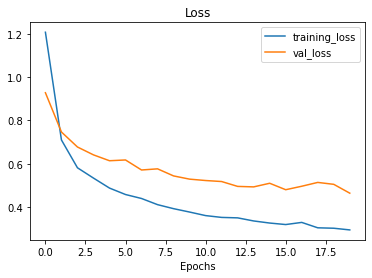

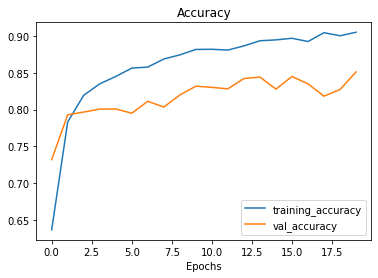

In [ ]:
plot_loss_curves(efficientnet_history)


Actual: blue_whale


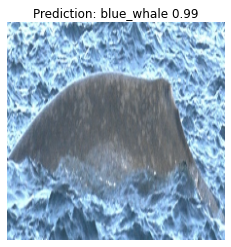

In [ ]:
import random
import os
from os.path import join, split

validation_imagenames = valid_generator.filenames
r = random.randint(0, len(validation_imagenames))
random_imagename = validation_imagenames[r]
image_path = join('top_10_valid/', random_imagename)
pred_and_plot(efficientnet_model, image_path, classes, top_10_valid_df)

In [ ]:
Y_pred = efficientnet_model.predict(valid_generator)

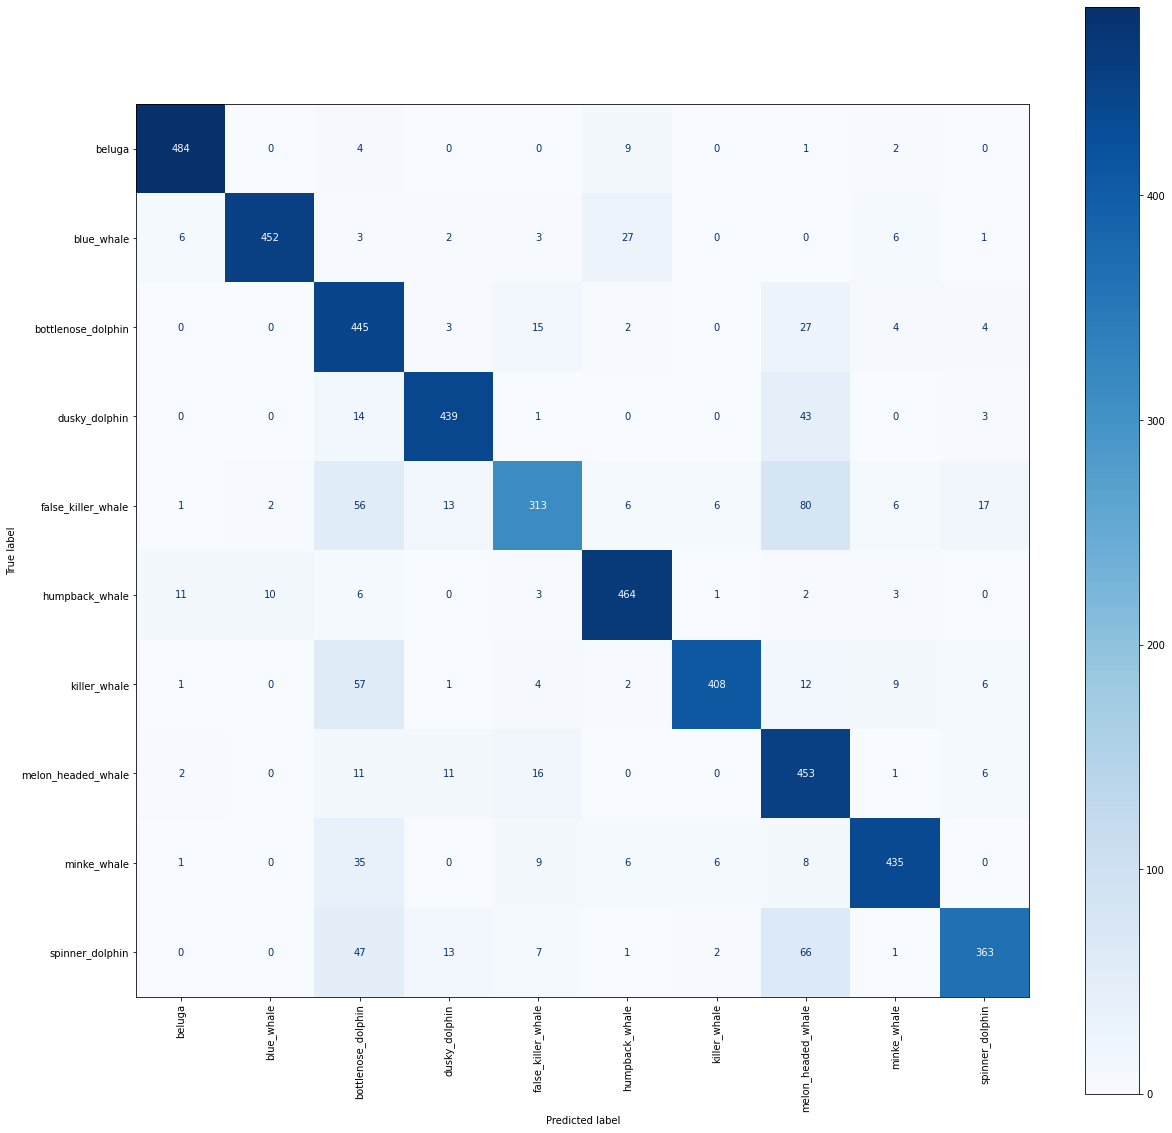

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

class_counts = train_df.species.value_counts()
top_10_classes = class_counts[:10]
classes = top_10_classes.index.tolist()
classes.sort()

y_pred = np.argmax(Y_pred, axis=1)
y_test = valid_generator.classes
labels = classes

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(cmap=plt.cm.Blues, ax=ax)
for label in ax.get_xticklabels():
  label.set_rotation(90)
#plt.show()


In [ ]:
efficientnet_model.save('top_10_20epochs_effnet')

INFO:tensorflow:Assets written to: top_10_20epochs_effnet/assets


INFO:tensorflow:Assets written to: top_10_20epochs_effnet/assets


In [ ]:
!zip -r top_10_20epochs_effnet.zip top_10_20epochs_effnet/
!mv top_10_20epochs_effnet.zip drive/MyDrive

  adding: top_10_20epochs_effnet/ (stored 0%)
  adding: top_10_20epochs_effnet/assets/ (stored 0%)
  adding: top_10_20epochs_effnet/saved_model.pb (deflated 91%)
  adding: top_10_20epochs_effnet/keras_metadata.pb (deflated 81%)
  adding: top_10_20epochs_effnet/variables/ (stored 0%)
  adding: top_10_20epochs_effnet/variables/variables.index (deflated 79%)
  adding: top_10_20epochs_effnet/variables/variables.data-00000-of-00001 (deflated 9%)


## Splitting data for group

In [ ]:
!unzip train2.csv.zip

Archive:  train2.csv.zip
  inflating: train2.csv              


In [ ]:
!unzip drive/MyDrive/cropped_train_images.zip

In [ ]:
import pandas as pd
df = pd.read_csv('train2.csv')

df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin", 
                          "beluga": "beluga_whale"}, inplace=True)

In [ ]:
classes_count = df.species.value_counts()
top_10_classes = classes_count[:10].index
top_10_classes

Index(['bottlenose_dolphin', 'beluga_whale', 'humpback_whale', 'blue_whale',
       'false_killer_whale', 'dusky_dolphin', 'killer_whale',
       'spinner_dolphin', 'melon_headed_whale', 'minke_whale'],
      dtype='object')

In [ ]:
classes_count

bottlenose_dolphin           10781
beluga_whale                  7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

Let's see here... if we take 200 for test size, that leaves 917 for validation+train

In [ ]:
!mkdir 200_test_images

In [ ]:
src = 'cropped_train_images/'
dst = '200_test_images/'

In [ ]:
import os
import math
import shutil 
from os.path import join

def copy_data_and_get_df(src, dst, df, num_classes=10, max_imgs=100):
  """
  Copies a dataset to max images per class (folder files and dataframe)
  src = source dir
  dst = dest dir
  df = dataframe of source files
  num_classes = number of (top) classes to copy (default: 10)
  max_imgs = max images per class

  Returns the tuple: (old dataframe - split data, split data dataframe)
  """
  df_new =  pd.DataFrame(columns=df.columns.tolist())
  
  files_moved = 0
  #classes = df.species.unique().tolist()
  # modified for top ten classes 
  class_counts = df.species.value_counts()
  top_10_classes = class_counts[:num_classes]
  classes = top_10_classes.index.tolist()
  print(f'Classes to move: {classes}')
  for cls in classes:
    class_files_moved = 0
    class_filenames = df.loc[df.species == cls].image.tolist()
    for class_file in class_filenames:
      if class_files_moved == max_imgs:
        break
      #shutil.move(join(src, class_file), join(dst, class_file))
      shutil.copy2(join(src, class_file), join(dst, class_file))
      row = df.loc[df.image == class_file]
      df_new = pd.concat([df_new, row], join='inner')
      class_files_moved += 1
    files_moved += class_files_moved
    print(f'Copied {class_files_moved} for class {cls}')  
  print(f'Total files copied: {files_moved}')
  df_old_minus_new = pd.concat([df, df_new, df_new]).drop_duplicates(keep=False)
  print(f'Length of old df: {len(df)}')
  print(f'Length of old-new_df: {len(df_old_minus_new)}')
  print(f'Length of new_df: {len(df_new)}')
  return df_old_minus_new, df_new

In [ ]:
df_total_minus_test, df_test = copy_data_and_get_df(src, dst, df, 10, 200)


In [ ]:
df_total_minus_test.species.value_counts()

In [ ]:
!mkdir 200_valid_images

mkdir: cannot create directory ‘200_valid_images’: File exists


In [ ]:
src = 'cropped_train_images/'
dst = '200_valid_images/'

In [ ]:
df_total_minus_test_valid, df_valid = copy_data_and_get_df(src, dst, df_total_minus_test, 10, 200)

Classes to move: ['bottlenose_dolphin', 'beluga_whale', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'killer_whale', 'spinner_dolphin', 'melon_headed_whale', 'minke_whale']
Copied 200 for class bottlenose_dolphin
Copied 200 for class beluga_whale
Copied 200 for class humpback_whale
Copied 200 for class blue_whale
Copied 200 for class false_killer_whale
Copied 200 for class dusky_dolphin
Copied 200 for class killer_whale
Copied 200 for class spinner_dolphin
Copied 200 for class melon_headed_whale
Copied 200 for class minke_whale
Total files copied: 2000
Length of old df: 49033
Length of old-new_df: 47033
Length of new_df: 2000


In [ ]:
df_total_minus_test_valid.species.value_counts()

bottlenose_dolphin           10381
beluga_whale                  7043
humpback_whale                6992
blue_whale                    4430
false_killer_whale            2926
dusky_dolphin                 2739
killer_whale                  2055
fin_whale                     1324
spinner_dolphin               1300
melon_headed_whale            1289
minke_whale                   1208
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

In [ ]:
!mkdir 1200_train_images
src = 'cropped_train_images/'
dst = '1200_train_images/'

In [ ]:
df_total_minus_test_valid_train, df_train = copy_data_and_get_df(src, dst, df_total_minus_test_valid, 10, 1208)

Classes to move: ['bottlenose_dolphin', 'beluga_whale', 'humpback_whale', 'blue_whale', 'false_killer_whale', 'dusky_dolphin', 'killer_whale', 'fin_whale', 'spinner_dolphin', 'melon_headed_whale']
Copied 1208 for class bottlenose_dolphin
Copied 1208 for class beluga_whale
Copied 1208 for class humpback_whale
Copied 1208 for class blue_whale
Copied 1208 for class false_killer_whale
Copied 1208 for class dusky_dolphin
Copied 1208 for class killer_whale
Copied 1208 for class fin_whale
Copied 1208 for class spinner_dolphin
Copied 1208 for class melon_headed_whale
Total files copied: 12080
Length of old df: 47033
Length of old-new_df: 34953
Length of new_df: 12080


In [ ]:
df_train.species.value_counts()

bottlenose_dolphin    1208
beluga_whale          1208
humpback_whale        1208
blue_whale            1208
false_killer_whale    1208
dusky_dolphin         1208
killer_whale          1208
fin_whale             1208
spinner_dolphin       1208
melon_headed_whale    1208
Name: species, dtype: int64

In [ ]:
df_train.to_csv('1200_train.csv')
df_test.to_csv('200_test.csv')
df_valid.to_csv('200_valid.csv')
df_total_minus_test_valid_train.to_csv('total_min_all_split.csv')
df_total_minus_test_valid.to_csv('total_min_test_valid.csv')
df_total_minus_test.to_csv('total_min_test.csv')

In [ ]:
# test data
!mkdir test_data
!mv 200_test.csv test_data
!mv 200_test_images/ test_data
!zip -r test_data.zip test_data/
!mv test_data.zip drive/MyDrive/

In [ ]:
# valid data
!mkdir valid_data
!mv 200_valid.csv valid_data 
!mv 200_valid_images/ valid_data/
!zip -r valid_data.zip valid_data/
!mv valid_data.zip drive/MyDrive

In [ ]:
# train_data
!mkdir train_data 
!mv 1200_train.csv train_data 
!mv 1200_train_images/ train_data/
!zip -r train_data.zip train_data/
!mv train_data.zip drive/MyDrive

In [ ]:
!mkdir misc_csv_cropped
!mv total_min* misc_csv_cropped
!zip -r misc_csv_cropped.zip misc_csv_cropped/
!mv misc_csv_cropped.zip drive/MyDrive

  adding: misc_csv_cropped/ (stored 0%)
  adding: misc_csv_cropped/total_min_test.csv (deflated 60%)
  adding: misc_csv_cropped/total_min_test_valid.csv (deflated 60%)
  adding: misc_csv_cropped/total_min_all_split.csv (deflated 60%)


In [ ]:
len(df_train.species.unique()),len(df_valid.species.unique()),len(df_test.species.unique())

(10, 10, 10)

In [ ]:
df_train.head()

,image,species,individual_id,box
1896,09aef98ac6b15f.jpg,bottlenose_dolphin,02da0e68dccd,268 706 1991 1211
1904,09be27e4269796.jpg,bottlenose_dolphin,0b2973489685,703 792 2427 1406
1908,09c31660c97b44.jpg,bottlenose_dolphin,e69d5f9f8d1e,1301 818 1828 1132
1911,09c58b5fc1fd31.jpg,bottlenose_dolphin,b9907151f66e,1030 962 1890 1234
1914,09c7afcef3e519.jpg,bottlenose_dolphin,d2cbc97c2c48,1308 508 2557 1196


In [ ]:
df_valid.head()

,image,species,individual_id,box
962,05121433889fb1.jpg,bottlenose_dolphin,480677e8cf20,0 505 1319 1037
967,05153c340144d8.jpg,bottlenose_dolphin,cb3a4bb8b4dc,946 753 3600 1371
976,051f830b518eea.jpg,bottlenose_dolphin,a45625e2e634,595 274 2940 1236
977,051fef9034915d.jpg,bottlenose_dolphin,7770c85b0e5e,NaN
979,0523ee284376d1.jpg,bottlenose_dolphin,0616562235a9,1432 910 2441 1385


In [ ]:
df_test.head()

,image,species,individual_id,box
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,1 91 2636 1495
5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e,259 443 2053 1068
9,000c476c11bad5.jpg,bottlenose_dolphin,b11b2404c7e3,1234 696 2257 1210
12,00144776eb476d.jpg,bottlenose_dolphin,b9907151f66e,1394 328 3271 926
14,00177f3c614d1e.jpg,bottlenose_dolphin,812be36c2aef,619 1100 2071 1849


In [ ]:
df_valid.species.value_counts()
df_train.species.value_counts()
df_test.species.value_counts()

bottlenose_dolphin    200
beluga_whale          200
humpback_whale        200
blue_whale            200
false_killer_whale    200
dusky_dolphin         200
killer_whale          200
spinner_dolphin       200
melon_headed_whale    200
minke_whale           200
Name: species, dtype: int64